# Preprocessing Input Images
## Imports

In [1]:
import os
import re
import numpy as np
import random
import shutil
import pandas as pd
import sklearn.metrics as mt
import matplotlib.pyplot as plt
import imgaug as ia
from imgaug import augmenters as iaa
from PIL import Image, ImageChops, ImageOps
from skimage import io
from sklearn.model_selection import train_test_split
%matplotlib inline

## Initializations

In [2]:
# preprocessing all folders
folder_path = 'raw_data'
#normal_frames_folder = 'normal_frames'
tumor_folders = ['malignant','benign']
normal_folders = ['normal_train', 'normal_test']
processed_folder = 'processed_data'
aug_folder = 'augmented_data'
final_folder = 'final_data'
previous_folder = 'previous_data'
train_label = 'train'
test_label = 'test'
valid_label = 'valid'
experiment_labels = {'NBM': ['normal','benign','malignant'], 
                     'NT': ['normal','tumor'], 
                     'BM': ['benign','malignant']}
log_folder = 'training_summaries'

## Functions

In [3]:
def enrich_normal(foldername, destination, sample_size, random_state=None):
    files = os.listdir(foldername)
    if random_state != None: 
        random.seed(random_state)
    samples = random.sample(files, sample_size)
    if not os.path.exists(destination):
        os.makedirs(destination)
    for sample in samples:
        shutil.copyfile(os.path.join(foldername,sample), os.path.join(destination,sample)) 
    
def find_dark_borders(seq, threshold):
    """This will return borders of a sequence of numbers. It uses difference of the sequence and 
    finds positive and negative big jumps at the begining and end of a sequence. This assumes margins
    are lower values than the middle values of sequence.
    :param seq: A sequence of numbers
    :param threshold: If positive, it is the value under which the difference is cut from beginning and end of the 
    sequence. If negative, it is the multiples of standard deviation to use to cut.
    """
    seq_diff = seq[1:] - seq[:-1]
    if threshold < 0:
        threshold = abs(np.std(seq_diff) * threshold)
    first_half = seq_diff[:len(seq_diff)/2]
    second_half = seq_diff[len(seq_diff):len(seq_diff)/2:-1]
    try:
        left = next(i for i,v in enumerate(first_half) if v > threshold)
    except:
        left = -1
    try:
        right = next(i for i,v in enumerate(second_half) if v < (threshold * -1))
    except StopIteration:
        right = -1
    return(left + 1, len(seq) - right - 1)


def auto_crop_dark_margin(im, threshold):
    """This will get a PIL image and crops the dark borders.
    :param im: A PIL.Image object
    :param threshold: If positive, it is the value under which the difference of pixel values is cut. 
    If negative, it is the multiples of standard deviation to use to cut.
    """
    img = np.asarray(im) 
    cols = np.mean(img, 0).astype(int)
    rows = np.mean(img, 1).astype(int)
    l,r = find_dark_borders(cols, threshold)
    u,d = find_dark_borders(rows, threshold)
    return im.crop((l,u,r,d))


def square(im):
    w, h = im.size
    if w == h:
        return im
    s = min(w, h)
    return im.crop(((w-s)/2, (h-s)/2, (w+s)/2, (h+s)/2))  


def pack_subfolders(main_folders, output_folder, file_format='jpg'):
    """Reads the images in the all subfolders of given list of folders and packs them into an ImageCollection.
    :param main_folders: List of main class folders to combine images inside
    :param output_folder: Path of output folder
    :param file_format: The extension of image file, defaults to 'jpg'
    """
    image_collections = []
    for class_folder in main_folders:
        current_folder = os.path.join(folder_path, class_folder)
        subfolders = os.listdir(current_folder)
        full_folders = [os.path.join(current_folder, folder, '*.' + file_format) for folder in subfolders 
                       if os.path.isdir(os.path.join(current_folder, folder))]
        all_subfolders = os.pathsep.join(full_folders)
        image_collections.append((io.ImageCollection(all_subfolders), 
                                  os.path.join(output_folder, class_folder)))
    return image_collections


def divide_train_valid_test(image_collections, train_ratio, 
                           train_label='train', test_label='test', valid_label='valid',
                           random_state=1234):
    train_data = []
    test_data = []
    valid_data = []
    for imgcol, outfolder in image_collections:
        train, valid_test = train_test_split(imgcol.files, train_size=train_ratio, random_state=random_state)
        valid, test = train_test_split(valid_test, train_size=0.5, random_state=random_state)
        train_data.append((io.ImageCollection(train), '_'.join([outfolder, train_label])))
        valid_data.append((io.ImageCollection(valid), '_'.join([outfolder, valid_label])))
        test_data.append((io.ImageCollection(test), '_'.join([outfolder, test_label])))

        
    return (train_data, valid_data, test_data)

def specifity(P, R, A):
    denom = R*(1-P) + P*(1-R)
    FP = (1-A) * R * (1-P) / denom
    TN = A - (R * P * (1-A) / denom)
    return TN / (TN + FP)

## Pack Benign and Malignant

In [4]:
if os.path.exists(processed_folder):
    shutil.rmtree(processed_folder)

#benign and malignat image collections
BM_image_collections = pack_subfolders(main_folders=tumor_folders, 
                                       output_folder=processed_folder,
                                       file_format='jpg')

BM_train_ics, BM_valid_ics, BM_test_ics = divide_train_valid_test(BM_image_collections, 
                                                                  train_ratio=0.8,
                                                                  train_label=train_label, 
                                                                  test_label=test_label,
                                                                  valid_label=valid_label)    

BM_train_size = sum([len(imgcol) for imgcol, _ in BM_train_ics])
BM_valid_size = sum([len(imgcol) for imgcol, _ in BM_valid_ics])
BM_test_size = sum([len(imgcol) for imgcol, _ in BM_test_ics])

for imgcol, outfolder in BM_train_ics + BM_valid_ics + BM_test_ics:
    os.makedirs(outfolder)
    
    for i, img in enumerate(imgcol):
        im = Image.fromarray(img)
        im = ImageOps.grayscale(im)                
        w,h = im.size
        im = im.crop((1,1,w-1,h-1))
        img_trim = auto_crop_dark_margin(im, -3)

        m = re.search('/(.+)_', outfolder)
        if m:
            file_name = m.group(1)
        else:
            file_name = "image"
        img_trim.save(os.path.join(outfolder, "{}_{}.jpg".format(file_name,i)), "JPEG")


## Clean Normal Data 

In [5]:
# Normal datasets come from variety of data folders each needs to be prepared differenlty
# look into normal_notCleaned folder in raw-data folder
normal_width = 300
normal_height = 300
random_width_crop = 20
random_height_crop = 20

ics = pack_subfolders(main_folders = normal_folders, output_folder=processed_folder, file_format='jpg')

for imgcol, outfolder in ics:
    os.makedirs(outfolder)
    i = 0 
    
    random.seed(1234)
    random.shuffle(imgcol.files)
    imgcol = io.ImageCollection(imgcol.files)

    for img in imgcol:
        im = Image.fromarray(img)
        if test_label in outfolder:
            im = im.crop([200, 126, 790, 546])
        im = ImageOps.grayscale(im)                
        w,h = im.size
        rnd_w = normal_width + random.randint(-1*random_width_crop, random_width_crop)
        rnd_h = normal_height + random.randint(-1*random_height_crop, random_height_crop)
        img_trim = im.crop(((w - rnd_w) / 2, 
                   (h - rnd_h) / 2,
                   (w + rnd_w) / 2, 
                   (h + rnd_h) / 2))
        img_trim.save(os.path.join(outfolder, "normal_{}.jpg".format(i)), "JPEG")
        i += 1
        if (train_label in outfolder) and (i == BM_train_size):
            break
        elif (test_label in outfolder) and (i == BM_test_size):
            outfolder = outfolder.replace(test_label, valid_label)
            os.makedirs(outfolder)
            i = 0
        elif (valid_label in outfolder) and (i == BM_valid_size):
            break


## Augmentation

In [6]:
if os.path.exists(aug_folder):
    shutil.rmtree(aug_folder)

processed_folders = os.listdir(processed_folder)

original = iaa.Sequential([iaa.Noop()])
rotation = iaa.Sequential([iaa.Affine(rotate=(-20,20), mode='wrap'), iaa.Crop(percent=0.1), iaa.Flipud(0.5)])
shear = iaa.Sequential([iaa.Affine(shear=(-25,25), mode='wrap'), iaa.Crop(percent=0.1)])
shear_rotation = iaa.Sequential([iaa.Affine(shear=(-25,25), rotate=(-20,20), mode='wrap'), iaa.Crop(percent=0.1), iaa.Flipud(0.5), iaa.Dropout(0.1)])
translation = iaa.Sequential([iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}), iaa.Crop(percent=0.1)])
sharpen = iaa.Sequential([iaa.Sharpen(alpha=(0.5, 1.0), lightness=(0.75, 1.5))])
contrast = iaa.Sequential([iaa.ContrastNormalization((0.5, 2.0))])
dropout = iaa.Sequential([iaa.Dropout(0.1)])

augmentation = {'original': (original, 1)
                #'rotate': (rotation, 5),
                #'shear': (shear, 5), 
                #'sharp': (sharpen, 5),
                #'contrast': (contrast, 5),
                #'trans': (translation, 5),
                #'dropout': (dropout, 1),
                #'shrrot': (shear_rotation, 5)
                
                }

for subfolder in processed_folders:
    subfolder_path = os.path.join(processed_folder, subfolder)
    if not os.path.isdir(subfolder_path):
        continue
    os.makedirs(os.path.join(aug_folder, subfolder))
    
    imgcol = io.ImageCollection(os.path.join(subfolder_path, '*.jpg' ))
        
    for i, img in enumerate(imgcol):
        image_file_name = os.path.splitext(imgcol.files[i])[0]
        image_file_name = image_file_name.replace(processed_folder, aug_folder)
        
        if test_label in image_file_name:
            im = Image.fromarray(img)
            im.save("{}_nohash_{}.jpg".format(image_file_name, 'original'), "JPEG")
            continue
        
        for key, value in augmentation.iteritems():
            seq, aug_num = value
            for j in xrange(aug_num):
                im = Image.fromarray(seq.augment_image(np.expand_dims(img,axis=2))[:,:,0])
                im.save("{}_nohash_{}_{}.jpg".format(image_file_name, key, j), "JPEG")

    print('Folder {} was generated.'.format(subfolder))            

Folder benign_test was generated.
Folder malignant_test was generated.
Folder benign_train was generated.
Folder benign_valid was generated.
Folder normal_train was generated.
Folder normal_valid was generated.
Folder malignant_valid was generated.
Folder malignant_train was generated.
Folder normal_test was generated.


## Final Datasets for each Experiment

In [7]:
if os.path.exists(final_folder):
    shutil.rmtree(final_folder)

for key in experiment_labels.keys():
    for l in experiment_labels[key]:
        os.makedirs(os.path.join(final_folder, key, l))
        os.makedirs(os.path.join(final_folder, test_label+ key, l))
        
    print key, experiment_labels[key]
    



BM ['benign', 'malignant']
NT ['normal', 'tumor']
NBM ['normal', 'benign', 'malignant']


In [8]:
aug_folders = os.listdir(aug_folder)
for a in aug_folders:
    a_folder = os.path.join(aug_folder, a)
    m = re.search(aug_folder + '/(.+)', a_folder)
    if not m:
        continue
    pattern = m.group(1).split('_')
    for group in [train_label, test_label, valid_label]:
        if group == test_label:
            prefix = test_label
        else:
            prefix = ''
        if (len(pattern) >=2) and (group in pattern):
            images = os.path.join(aug_folder, pattern[0]+'_' + group, '*.jpg')
            ic = io.ImageCollection(images)
            ic_files = ic.files
            for i in range(len(ic_files)):
                filename = os.path.basename(ic_files[i])
                shutil.copyfile(ic_files[i], 
                                os.path.join(final_folder,prefix+'NBM',pattern[0], "{}_{}".format(group, filename)))
                if (pattern[0] == 'benign') or (pattern[0] == 'malignant'):
                    shutil.copyfile(ic_files[i], 
                                    os.path.join(final_folder,prefix+'BM',pattern[0], "{}_{}".format(group, filename))) 
                    shutil.copyfile(ic_files[i], 
                                    os.path.join(final_folder,prefix+'NT','tumor', "{}_{}".format(group, filename))) 
                else:
                    shutil.copyfile(ic_files[i], 
                                    os.path.join(final_folder,prefix+'NT',pattern[0], "{}_{}".format(group, filename)))
                  

# Training the Model
##  Tensorboard

In [9]:
def TB(log_folder, cleanup=False):

    if cleanup:
        !rm -R $log_folder

    os.system('pkill -f tensorboard')
    os.system('tensorboard --logdir {} > tensorboard.log &'.format(os.path.abspath(log_folder)))
        
        
# Run tensorboard
TB(log_folder, cleanup=True)

## Initializations

In [10]:
output_folder = final_folder
experiments = {'NBM': {'title': 'Normal_Benign_Malignant',
                       'graph_name': 'graph_NBM.pb',
                       'labels_name': 'labels_NBM.txt',
                       'bottlenecks_folder': 'bottlenecks_NBM',
                       'model_folder': 'inception',
                       'log_folder': 'training_summaries/NBM',
                       'train_folder': os.path.join(output_folder, 'NBM'),
                       'test_folder': os.path.join(output_folder, test_label+'NBM')}, 
               'NT': {'title': 'Normal_Tumor',
                      'graph_name': 'graph_NT.pb',
                      'labels_name': 'labels_NT.txt',
                      'bottlenecks_folder': 'bottlenecks_NT',
                      'model_folder': 'inception',
                      'log_folder': 'training_summaries/NT',
                      'train_folder': os.path.join(output_folder, 'NT'),
                      'test_folder': os.path.join(output_folder, test_label+'NT')},
               'BM': {'title': 'Benign_Malignant',
                      'graph_name': 'graph_BM.pb',
                      'labels_name': 'labels_BM.txt',
                      'bottlenecks_folder': 'bottlenecks_BM',
                      'model_folder': 'inception',
                      'log_folder': 'training_summaries/BM',
                      'train_folder': os.path.join(output_folder, 'BM'),
                      'test_folder': os.path.join(output_folder, test_label+'BM')},
               'OBM': {'title': 'Old_Benign_Malignant',
                      'graph_name': 'graph_OBM.pb',
                      'labels_name': 'labels_OBM.txt',
                      'bottlenecks_folder': 'bottlenecks_OBM',
                      'model_folder': 'inception',
                      'log_folder': 'training_summaries/OBM',
                      'train_folder': os.path.join(previous_folder, train_label),
                      'test_folder': os.path.join(previous_folder, test_label)}
              }


## Remove Old Trained Folders
### Run to remove cached bottlenecks if the data was changed in cells above

In [21]:
path = os.listdir('.')
bottle = filter(lambda x: 'bottlenecks' in x, path)
graph = filter(lambda x: 'graph' in x, path)

for i in bottle:
    shutil.rmtree(i)
    
for i in graph:
    os.remove(i)    

## Setting Current Experiment (NBM, NT, BM)
### Run this cell and the next 2 cells for each of experiments: NBM, NT, and BM before moving on
Set current_experiment to BM, NT, NBM then run

In [22]:
epochs = 20000
eval_steps = 100
train_batch_size = 200
validation_batch_size = 100
current_experiment = 'BM'
learning_rate = 0.01

graph_name = experiments[current_experiment]['graph_name']
labels_name = experiments[current_experiment]['labels_name']
bottlenecks_folder = experiments[current_experiment]['bottlenecks_folder']
model_folder = experiments[current_experiment]['model_folder']
log_folder = experiments[current_experiment]['log_folder']
train_folder = experiments[current_experiment]['train_folder']
test_folder = experiments[current_experiment]['test_folder']


## Start Training
### Run for each experiment

In [1]:
%run retrain.py \
--bottleneck_dir=$bottlenecks_folder \
--how_many_training_steps=$epochs \
--model_dir=$model_folder \
--summaries_dir=$log_folder \
--output_graph=$graph_name \
--output_labels=$labels_name \
--eval_step_interval=$eval_steps \
--image_dir=$train_folder \
--train_batch_size=$train_batch_size \
--validation_batch_size=$validation_batch_size \
--learning_rate=$learning_rate \
--testing_percentage=1 \
--validation_percentage=1 \
--print_misclassified_test_images 


## Evaluate Test Data
### Run for each experiment

In [2]:
folder_path = test_folder
result_file = 'predictions_{}.csv'.format(current_experiment)
%run label_image.py --graph=$graph_name --labels=$labels_name --image=$folder_path --predictions_path=$result_file

# Calculate Metrics

## BM

Accuracy: 72.0472440945
Precision: 0.713444213444, Recall: 0.715961244263, F1: 0.714412402806


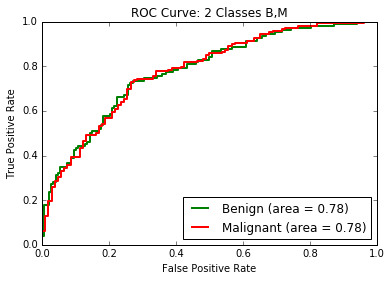

In [15]:
df_BM = pd.read_csv('predictions_BM.csv', header=None, names= ['path', 'label', 'pred'])
df_BM['true_label'] = df_BM.apply(lambda row: 'benign' if 'benign' in row['path'] else 'malignant', axis=1)

top_pred_BM = df_BM.sort_values(['path','pred'],ascending=False).groupby('path').first().reset_index()
top_pred_BM['true_label'] = top_pred_BM.apply(lambda row: 'benign' if 'benign' in row['path'] else 'malignant', axis=1)

print ("Accuracy: {}".format(sum(top_pred_BM['true_label'] == top_pred_BM['label']) * 100.0 / len(top_pred_BM)))


F1_BM_macro = mt.f1_score(y_true=list(top_pred_BM['true_label']),
                           y_pred=list(top_pred_BM['label']), 
                           labels=['benign', 'malignant'], average='macro')

P_BM_macro = mt.precision_score(y_true=list(top_pred_BM['true_label']),
                                 y_pred=list(top_pred_BM['label']), 
                                 labels=['benign', 'malignant'], average='macro')

R_BM_macro = mt.recall_score(y_true=list(top_pred_BM['true_label']),
                              y_pred=list(top_pred_BM['label']), 
                              labels=['benign', 'malignant'], average='macro')

print("Precision: {}, Recall: {}, F1: {}".format(P_BM_macro, R_BM_macro, F1_BM_macro))

df_true_B = df_BM[df_BM['label'] == 'benign']
FPR_B, TPR_B, _ = mt.roc_curve(y_true=list(df_true_B['true_label']),
                                          y_score=list(df_true_B['pred']),
                                          pos_label='benign')

df_true_M = df_BM[df_BM['label'] == 'malignant']
FPR_M, TPR_M, _ = mt.roc_curve(y_true=list(df_true_M['true_label']),
                                          y_score=list(df_true_M['pred']),
                                          pos_label='malignant')




roc_auc_B = mt.auc(FPR_B, TPR_B)
roc_auc_M = mt.auc(FPR_M, TPR_M)

lw = 2
plt.figure()
plt.plot(FPR_B, TPR_B, color='green',
         lw=lw, label='Benign (area = %0.2f)' % roc_auc_B)
plt.plot(FPR_M, TPR_M, color='red',
         lw=lw, label='Malignant (area = %0.2f)' % roc_auc_M)

plt.legend(loc='best')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: 2 Classes B,M")

plt.savefig('plots/ROC_BM.png', format='png', dpi=300)

## NBM

Precision: 0.802197802198, Recall: 0.800334954404, F1: 0.799289152258


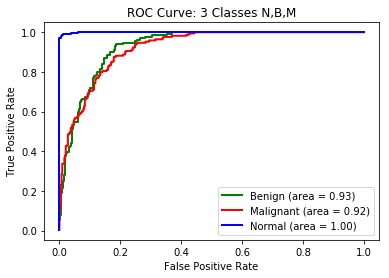

In [7]:
df_NBM = pd.read_csv('predictions_NBM.csv', header=None, names= ['path', 'label', 'pred'])
df_NBM['true_label'] = df_NBM.apply(lambda row: 'benign' if 'benign' in row['path'] else 'malignant' if 'malignant' in row['path'] else 'normal', axis=1)

top_pred_NBM = df_NBM.sort_values(['path','pred'],ascending=False).groupby('path').first().reset_index()
top_pred_NBM['true_label'] = top_pred_NBM.apply(lambda row: 'benign' if 'benign' in row['path'] else 'malignant' if 'malignant' in row['path'] else 'normal', axis=1)


F1_NBM_macro = mt.f1_score(y_true=list(top_pred_NBM['true_label']),
                           y_pred=list(top_pred_NBM['label']), 
                           labels=['normal', 'benign', 'malignant'], average='macro')

P_NBM_macro = mt.precision_score(y_true=list(top_pred_NBM['true_label']),
                                 y_pred=list(top_pred_NBM['label']), 
                                 labels=['normal', 'benign', 'malignant'], average='macro')

R_NBM_macro = mt.recall_score(y_true=list(top_pred_NBM['true_label']),
                              y_pred=list(top_pred_NBM['label']), 
                              labels=['normal', 'benign', 'malignant'], average='macro')

print("Precision: {}, Recall: {}, F1: {}".format(P_NBM_macro, R_NBM_macro, F1_NBM_macro))

df_true_B = df_NBM[df_NBM['label'] == 'benign']
FPR_B, TPR_B, _ = mt.roc_curve(y_true=list(df_true_B['true_label']),
                                          y_score=list(df_true_B['pred']),
                                          pos_label='benign')

df_true_M = df_NBM[df_NBM['label'] == 'malignant']
FPR_M, TPR_M, _ = mt.roc_curve(y_true=list(df_true_M['true_label']),
                                          y_score=list(df_true_M['pred']),
                                          pos_label='malignant')

df_true_N = df_NBM[df_NBM['label'] == 'normal']
FPR_N, TPR_N, _ = mt.roc_curve(y_true=list(df_true_N['true_label']),
                                          y_score=list(df_true_N['pred']),
                                          pos_label='normal')



roc_auc_B = mt.auc(FPR_B, TPR_B)
roc_auc_M = mt.auc(FPR_M, TPR_M)
roc_auc_N = mt.auc(FPR_N, TPR_N)

lw = 2
plt.figure()
plt.plot(FPR_B, TPR_B, color='green',
         lw=lw, label='Benign (area = %0.2f)' % roc_auc_B)
plt.plot(FPR_M, TPR_M, color='red',
         lw=lw, label='Malignant (area = %0.2f)' % roc_auc_M)
plt.plot(FPR_N, TPR_N, color='blue',
         lw=lw, label='Normal (area = %0.2f)' % roc_auc_N)

plt.legend(loc='best')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: 3 Classes N,B,M")

plt.savefig('plots/ROC_NBM.png', format='png', dpi=300)

## Evaluate BM based on NT
### Make sure to run training on all 3 experiments (BM, NT, NBM) before running this cell

In [24]:
df_NT = pd.read_csv('predictions_NT.csv', header=None, names= ['path', 'label', 'pred'])
top_pred = df_NT.sort_values(['path','pred'],ascending=False).groupby('path').first().reset_index()
tumor = top_pred[top_pred['label'] == 'tumor']

dest = os.path.join(output_folder,test_label+'BMNT','tumor')
if os.path.exists(dest):
    shutil.rmtree(dest)
os.makedirs(dest)
for idx, row in tumor.iterrows():
    shutil.copy(row['path'],os.path.join(dest,os.path.basename(row['path'])))
    

In [10]:
epochs = 1000
eval_steps = 10
current_experiment = 'BM'

graph_name = experiments[current_experiment]['graph_name']
labels_name = experiments[current_experiment]['labels_name']
bottlenecks_folder = experiments[current_experiment]['bottlenecks_folder']
model_folder = experiments[current_experiment]['model_folder']
log_folder = experiments[current_experiment]['log_folder']
train_folder = experiments[current_experiment]['train_folder']
test_folder = experiments[current_experiment]['test_folder']

test_folder = test_folder+'NT'


In [11]:
folder_path = test_folder
result_file = 'predictions_BMNT.csv'
%run label_image.py --graph=$graph_name --labels=$labels_name --image=$folder_path --predictions_path=$result_file

final_data/testBMNT/tumor/benign_0.jpg: malignant (score = 0.76811)
final_data/testBMNT/tumor/benign_0.jpg: benign (score = 0.23189)
final_data/testBMNT/tumor/benign_1.jpg: malignant (score = 0.62683)
final_data/testBMNT/tumor/benign_1.jpg: benign (score = 0.37317)
final_data/testBMNT/tumor/benign_10.jpg: malignant (score = 0.53819)
final_data/testBMNT/tumor/benign_10.jpg: benign (score = 0.46181)
final_data/testBMNT/tumor/benign_100.jpg: benign (score = 0.69512)
final_data/testBMNT/tumor/benign_100.jpg: malignant (score = 0.30488)
final_data/testBMNT/tumor/benign_101.jpg: malignant (score = 0.78035)
final_data/testBMNT/tumor/benign_101.jpg: benign (score = 0.21965)
final_data/testBMNT/tumor/benign_102.jpg: malignant (score = 0.76352)
final_data/testBMNT/tumor/benign_102.jpg: benign (score = 0.23648)
final_data/testBMNT/tumor/benign_103.jpg: malignant (score = 0.63843)
final_data/testBMNT/tumor/benign_103.jpg: benign (score = 0.36157)
final_data/testBMNT/tumor/benign_104.jpg: benign (s

## NT -> BM

Precision: 0.791153312489, Recall: 0.790650385694, F1: 0.790306396972


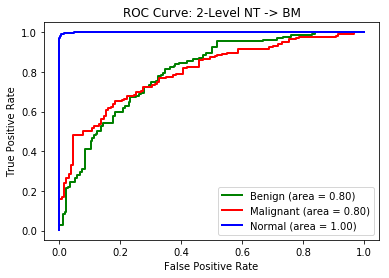

In [13]:
df_NT = pd.read_csv('predictions_NT.csv', header=None, names= ['path', 'label', 'pred'])
df_NT['true_label'] = df_NT.apply(lambda row: 'tumor' if 'tumor' in row['path'] else 'normal', axis=1)

top_pred_NT = df_NT.sort_values(['path','pred'],ascending=False).groupby('path').first().reset_index()
top_pred_N = top_pred_NT[top_pred_NT['label'] == 'normal']

df_BM = pd.read_csv('predictions_BMNT.csv', header=None, names= ['path', 'label', 'pred'])
df_BM['true_label'] = df_BM.apply(lambda row: 'benign' if 'benign' in row['path'] else 'malignant', axis=1)

top_pred_BM = df_BM.sort_values(['path','pred'],ascending=False).groupby('path').first().reset_index()
top_pred_N_BM = top_pred_N.append(top_pred_BM)
top_pred_N_BM['true_label'] = top_pred_N_BM.apply(lambda row: 'benign' if 'benign' in row['path'] else 'malignant' if 'malignant' in row['path'] else 'normal', axis=1)

print ("Accuracy: {}".format(sum(top_pred_NT['true_label'] == top_pred_NT['label']) * 100.0 / len(top_pred_NT)))

F1_N_BM_macro = mt.f1_score(y_true=list(top_pred_N_BM['true_label']),
                           y_pred=list(top_pred_N_BM['label']), 
                           labels=['normal', 'benign', 'malignant'], average='macro')

P_N_BM_macro = mt.precision_score(y_true=list(top_pred_N_BM['true_label']),
                                 y_pred=list(top_pred_N_BM['label']), 
                                 labels=['normal', 'benign', 'malignant'], average='macro')

R_N_BM_macro = mt.recall_score(y_true=list(top_pred_N_BM['true_label']),
                              y_pred=list(top_pred_N_BM['label']), 
                              labels=['normal', 'benign', 'malignant'], average='macro')

print("Precision: {}, Recall: {}, F1: {}".format(P_N_BM_macro, R_N_BM_macro, F1_N_BM_macro))


df_true_N = df_NT[df_NT['label'] == 'normal']

FPR_N, TPR_N, _ = mt.roc_curve(y_true=list(df_true_N['true_label']),
                                          y_score=list(df_true_N['pred']),
                                          pos_label='normal')

df_true_B = df_BM[df_BM['label'] == 'benign']
FPR_B, TPR_B, _ = mt.roc_curve(y_true=list(df_true_B['true_label']),
                                          y_score=list(df_true_B['pred']),
                                          pos_label='benign')

df_true_M = df_BM[df_BM['label'] == 'malignant']
FPR_M, TPR_M, _ = mt.roc_curve(y_true=list(df_true_M['true_label']),
                                          y_score=list(df_true_M['pred']),
                                          pos_label='malignant')




roc_auc_B = mt.auc(FPR_B, TPR_B)
roc_auc_M = mt.auc(FPR_M, TPR_M)
roc_auc_N = mt.auc(FPR_N, TPR_N)

lw = 2
plt.figure()
plt.plot(FPR_B, TPR_B, color='green',
         lw=lw, label='Benign (area = %0.2f)' % roc_auc_B)
plt.plot(FPR_M, TPR_M, color='red',
         lw=lw, label='Malignant (area = %0.2f)' % roc_auc_M)
plt.plot(FPR_N, TPR_N, color='blue',
         lw=lw, label='Normal (area = %0.2f)' % roc_auc_N)

plt.legend(loc='best')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: 2-Level NT -> BM")

plt.savefig('plots/ROC_NT_BM.png', format='png', dpi=300)

# Compare with previous CNN

In [10]:
from six.moves import cPickle as pickle
pickle_file = 'breast.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

('Training set', (17280, 40, 40), (17280,))
('Validation set', (2880, 40, 40), (2880,))
('Test set', (2880, 40, 40), (2880,))


In [11]:
if os.path.exists(previous_folder):
    shutil.rmtree(previous_folder)
datasets = [(train_dataset, train_labels), (valid_dataset, valid_labels), (test_dataset, test_labels)]
os.makedirs(os.path.join(previous_folder,train_label,'benign'))
os.makedirs(os.path.join(previous_folder,train_label,'malignant'))


# Create training
for i in xrange(len(train_dataset)):
    im = Image.fromarray((train_dataset[i,:,:] + 0.5)*255)
    im = ImageOps.grayscale(im)
    label = 'benign' if train_labels[i] == 0 else 'malignant'
    im.save(os.path.join(previous_folder,train_label,label,'{}_{}_{}.jpg'.format(train_label,label,i)), "JPEG")

    
# Create validation
for i in xrange(len(valid_dataset)):
    im = Image.fromarray((valid_dataset[i,:,:] + 0.5)*255)
    im = ImageOps.grayscale(im)
    label = 'benign' if valid_labels[i] == 0 else 'malignant'
    im.save(os.path.join(previous_folder,train_label,label,'{}_{}_{}.jpg'.format(valid_label,label,i)), "JPEG")
    
    
# Create testing
os.makedirs(os.path.join(previous_folder,test_label,'benign'))
os.makedirs(os.path.join(previous_folder,test_label,'malignant'))
for i in xrange(len(test_labels)):
    im = Image.fromarray((test_dataset[i,:,:] + 0.5)*255)
    im = ImageOps.grayscale(im)
    label = 'benign' if test_labels[i] == 0 else 'malignant'
    im.save(os.path.join(previous_folder,test_label,label,'{}_{}.jpg'.format(label,i)), "JPEG")    


## Old BM Comparison Metrics
### Run OBM experiment before running this cell

Accuracy: 68.6111111111
Precision: 0.69055895714, Recall: 0.686111111111, F1: 0.684268736357


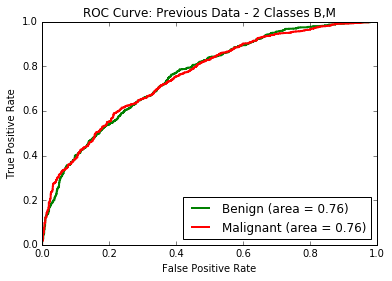

In [20]:
df_OBM = pd.read_csv('predictions_OBM.csv', header=None, names= ['path', 'label', 'pred'])
df_OBM['true_label'] = df_OBM.apply(lambda row: 'benign' if 'benign' in row['path'] else 'malignant', axis=1)

top_pred_OBM = df_OBM.sort_values(['path','pred'],ascending=False).groupby('path').first().reset_index()
top_pred_OBM['true_label'] = top_pred_OBM.apply(lambda row: 'benign' if 'benign' in row['path'] else 'malignant', axis=1)

print ("Accuracy: {}".format(sum(top_pred_OBM['true_label'] == top_pred_OBM['label']) * 100.0 / len(top_pred_OBM)))

F1_OBM_macro = mt.f1_score(y_true=list(top_pred_OBM['true_label']),
                           y_pred=list(top_pred_OBM['label']), 
                           labels=['benign', 'malignant'], average='macro')

P_OBM_macro = mt.precision_score(y_true=list(top_pred_OBM['true_label']),
                                 y_pred=list(top_pred_OBM['label']), 
                                 labels=['benign', 'malignant'], average='macro')

R_OBM_macro = mt.recall_score(y_true=list(top_pred_OBM['true_label']),
                              y_pred=list(top_pred_OBM['label']), 
                              labels=['benign', 'malignant'], average='macro')

print("Precision: {}, Recall: {}, F1: {}".format(P_OBM_macro, R_OBM_macro, F1_OBM_macro))

df_true_B = df_OBM[df_OBM['label'] == 'benign']
FPR_B, TPR_B, _ = mt.roc_curve(y_true=list(df_true_B['true_label']),
                                          y_score=list(df_true_B['pred']),
                                          pos_label='benign')

df_true_M = df_OBM[df_OBM['label'] == 'malignant']
FPR_M, TPR_M, _ = mt.roc_curve(y_true=list(df_true_M['true_label']),
                                          y_score=list(df_true_M['pred']),
                                          pos_label='malignant')




roc_auc_B = mt.auc(FPR_B, TPR_B)
roc_auc_M = mt.auc(FPR_M, TPR_M)

lw = 2
plt.figure()
plt.plot(FPR_B, TPR_B, color='green',
         lw=lw, label='Benign (area = %0.2f)' % roc_auc_B)
plt.plot(FPR_M, TPR_M, color='red',
         lw=lw, label='Malignant (area = %0.2f)' % roc_auc_M)

plt.legend(loc='best')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Previous Data - 2 Classes B,M")

plt.savefig('plots/ROC_BM.png', format='png', dpi=300)

In [16]:
P = 0.713444213444
R = 0.715961244263
A = 0.720472440945
print (specifity(P, R, A))


0.724789794544


# Finish up

In [7]:
!pkill -f tensorboard